In [15]:
import os
from typing import TypedDict, Annotated, List
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from dotenv import load_dotenv
import joblib
import numpy as np

load_dotenv()

class GraphState(TypedDict):
    patient_data: dict
    prediction_result: dict 
    decision: str
    action_result: str
    final_summary: str

In [22]:
import requests
from langchain_core.tools import tool

EHR_API_BASE_URL = "http://127.0.0.1:8080"

@tool
def data_ingestion_agent(patientId: str) -> dict:
    """
    Fetches a patient's record from the EHR system API using their patient ID.
    Returns the patient data as a dictionary or an error message if not found.
    """
    print(f"INGESTION AGENT: Fetching data for patient {patientId} from EHR API---")
    
    api_url = f"{EHR_API_BASE_URL}/api/patient-records/patient_{patientId}"
    
    try:
        response = requests.get(api_url)
        
        response.raise_for_status()
        
        patient_data = response.json()
        print(f"INGESTION AGENT: Successfully retrieved data for patient {patientId}")
        return patient_data
        
    except requests.exceptions.HTTPError as http_err:
        print(f"INGESTION AGENT ERROR: HTTP error occurred: {http_err}")
        return {"error": "Patient not found in EHR system.", "patientId": patientId}
        
    except requests.exceptions.RequestException as req_err:
        print(f"INGESTION AGENT ERROR: Could not connect to EHR API: {req_err}")
        return {"error": "Could not connect to the EHR API. Please check if the Java service is running.", "details": str(req_err)}



In [32]:
import operator
from typing import TypedDict, Annotated, List, Union
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.tools import tool

MODEL_PATH = "parkinsons_model.pkl" 
SCALER_PATH = "standscaler.pkl"  # e.g., the StandardScaler you trained with

try:
    PARKINSON_MODEL = joblib.load(MODEL_PATH)
    DATA_SCALER = joblib.load(SCALER_PATH)
    print("✅ Parkinson's model and scaler loaded successfully.")
except FileNotFoundError as e:
    print(f"❌ ERROR: Could not load model/scaler file. {e}")
    print("Please check the file paths. The prediction agent will not work.")
    PARKINSON_MODEL = None
    DATA_SCALER = None

@tool
def disease_prediction_agent(patient_data: dict) -> dict:
#     """
#     Predicts Chronic Kidney Disease (CKD) risk based on eGFR value
#     and returns a structured dictionary.
#     """
#     print("RUNNING CKD PREDICTION")
    
#     # Ensure lab_results and egfr exist before accessing them
#     if "lab_results" not in patient_data or "egfr" not in patient_data["lab_results"]:
#         return {
#             "risk_level": "Unknown",
#             "reason": "eGFR value not found in patient data.",
#             "recommendation": "Please ensure a valid eGFR lab result is available."
#         }
        
#     egfr = patient_data["lab_results"]["egfr"]

#     if egfr < 30:
#         return {
#             "risk_level": "High",
#             "reason": f"eGFR is {egfr}, indicating severe (Stage 4/5) CKD.",
#             "recommendation": "Urgent consultation with a nephrologist is recommended."
#         }
#     elif egfr < 60:
#         return {
#             "risk_level": "Moderate",
#             "reason": f"eGFR is {egfr}, indicating moderate (Stage 3) CKD.",
#             "recommendation": "Follow-up appointment with a primary care physician or nephrologist is advised."
#         }
#     else:
#         return {
#             "risk_level": "Low",
#             "reason": f"eGFR is {egfr}, which is in the normal or mildly reduced range.",
#             "recommendation": "Continue routine monitoring as per standard guidelines."
#         }

    """
    Predicts Parkinson's Disease (PD) risk based on patient voice data
    using a pre-trained machine learning model.
    Returns a structured dictionary for the agentic system.
    """
    print("RUNNING PARKINSON'S PREDICTION (VOICE ANALYSIS)")

    if not PARKINSON_MODEL or not DATA_SCALER:
        return {
            "risk_level": "Error",
            "reason": "Parkinson's prediction model or scaler is not loaded.",
            "recommendation": "Please check server logs and model file paths."
        }

    # --- 1. Extract Features in the Correct Order ---
    # This is the list of 22 features you provided, in order.
    feature_names_in_order = [
        'fo', 'fhi', 'flo', 'Jitter_percent', 'Jitter_Abs', 'RAP', 'PPQ', 'DDP',
        'Shimmer', 'Shimmer_dB', 'APQ3', 'APQ5', 'APQ', 'DDA', 'NHR', 'HNR',
        'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE'
    ]

    try:
        # **ASSUMPTION:** All features are nested under a 'voiceAnalysis' key.
        # If they are at the top level, change this to:
        # voice_data = patient_data
        print("Extracting features from 'patient_data['voiceAnalysis']'...")
        voice_data = patient_data["voiceAnalysis"]
        
        # Build the feature list in the exact order required by the model
        feature_list = [voice_data[feature] for feature in feature_names_in_order]

    except KeyError as e:
        print(f"Error extracting features: {e}")
        return {
            "risk_level": "Unknown",
            "reason": f"Required feature not found in patient data: {e}. Check 'voiceAnalysis' data.",
            "recommendation": "Please ensure a valid voice analysis report is in the EHR data."
        }
    
    # --- 2. Preprocess and Predict ---
    try:
        # Convert features to a 2D numpy array for the scaler
        features_array = np.array([feature_list])
        
        # Scale the features
        scaled_features = DATA_SCALER.transform(features_array)
        
        # Make the prediction (e.g., [0] or [1])
        prediction = PARKINSON_MODEL.predict(scaled_features)
        
        # Get prediction probability (optional, but good for the 'reason')
        try:
            # [0] selects the first sample, [1] selects the probability of the *positive* class
            prediction_proba = PARKINSON_MODEL.predict_proba(scaled_features)[0]
            positive_prob = prediction_proba[1] 
        except AttributeError:
            positive_prob = "N/A" # Model might not support predict_proba
        except IndexError:
             # Handle cases where predict_proba might not be [prob_class_0, prob_class_1]
            positive_prob = prediction_proba[0] 

        # --- 3. Format the Output (Crucial!) ---
        # Map your model's output (0 or 1) to the "High"/"Low"
        # risk levels that your graph's router already knows.
        
        if prediction[0] == 1:  # Assuming 1 means "Positive for Parkinson's"
            risk = "High"
            reason = (f"Model positive for Parkinson's "
                      f"(Prob: {positive_prob*100:.2f}%) based on voice analysis.")
            recommend = "Urgent consultation with a neurologist is recommended for further evaluation."
        else: # Assuming 0 means "Negative"
            risk = "Low"
            # Calculate probability of negative class if possible
            neg_prob_display = f"{(1.0-positive_prob)*100:.2f}%" if positive_prob != "N/A" else "N/A"
            reason = (f"Model negative for Parkinson's "
                      f"(Prob: {neg_prob_display}) based on voice analysis.")
            recommend = "Continue routine monitoring as per standard guidelines."
            
        return {
            "risk_level": risk,
            "reason": reason,
            "recommendation": recommend
        }

    except Exception as e:
        print(f"Error during prediction: {e}")
        return {
            "risk_level": "Error",
            "reason": f"An error occurred during model prediction: {e}",
            "recommendation": "Consult technical support."
        }


✅ Parkinson's model and scaler loaded successfully.


In [33]:
import requests
from langchain_core.tools import tool
from typing import Optional

EHR_API_BASE_URL = "http://127.0.0.1:8080"

def _call_action_api(endpoint: str, payload: dict) -> str:
    """Helper function to make POST requests to the action API."""
    api_url = f"{EHR_API_BASE_URL}{endpoint}"
    try:
        response = requests.post(api_url, json=payload)
        response.raise_for_status()
        
        response_data = response.json()
        return response_data.get("message", "Action completed, no confirmation message.")
        
    except requests.exceptions.HTTPError as http_err:
        return f"API returned an error: {http_err.response.status_code} {http_err.response.text}"
    except requests.exceptions.RequestException as req_err:
        return f"Could not connect to the EHR Action API: {req_err}"

@tool
def schedule_appointment(specialist: str, urgency: str, patientId: Optional[str] = None) -> str:
    """
    Schedules a new appointment for a specific patient with a specialist.
    - specialist: The type of specialist required (e.g., 'endocrinologist', 'primary care physician').
    - urgency: The urgency of the appointment (e.g., 'urgent', 'standard').
    """
    print(f"TOOL: schedule_appointment for patient {patientId}")
    if not patientId:
        return "Error: patientId was not provided."
        
    endpoint = f"/api/appointments/schedule"
    payload = {"patientId": patientId, "specialist": specialist,}
    return _call_action_api(endpoint, payload)

@tool
def schedule_lab(lab: str, urgency: str, patientId: Optional[str] = None) -> str:
    """
    Schedules a new appointment for a specific patient with a specialist.
    - specialist: The type of specialist required (e.g., 'endocrinologist', 'primary care physician').
    - urgency: The urgency of the appointment (e.g., 'urgent', 'standard').
    """
    print(f"TOOL: schedule_lab for patient {patientId}")
    if not patientId:
        return "Error: patientId was not provided."
        
    endpoint = f"/api/lab-tests/schedule"
    payload = {"patientId": patientId, "test_type": lab}
    return _call_action_api(endpoint, payload)

@tool
def send_notification(message: str, patientId: Optional[str] = None) -> str:
    """
    Sends a notification message to a specific patient.
    - message: The content of the message to send.
    """
    print(f"TOOL: send_notification for patient {patientId}")
    if not patientId:
        return "Error: patientId was not provided."
        
    endpoint = f"/actions/{patientId}/send-notification"
    payload = {"message": message}
    return _call_action_api(endpoint, payload)

@tool
def log_note(note: str, patientId: Optional[str] = None) -> str:
    """
    Logs a clinical note to a patient's record in the EHR system.
    - note: The clinical note to log.
    """
    print(f"TOOL: log_note for patient {patientId}")
    if not patientId:
        return "Error: patientId was not provided."
        
    endpoint = f"/actions/{patientId}/log-note"
    payload = {"note": note}
    return _call_action_api(endpoint, payload)



In [34]:
import operator
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END
from langchain_core.messages import SystemMessage, HumanMessage


llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0)

action_tools = [schedule_appointment, schedule_lab, send_notification, log_note]

def ingest_data(state):
    """Node to call the data ingestion tool."""
    print("NODE: INGEST DATA")
    patientId = state['patient_data']['patientId']
    patient_info = data_ingestion_agent.invoke({"patientId": patientId})
    return {"patient_data": patient_info}

def predict_disease(state):
    """Node to call the disease prediction tool."""
    print("NODE: PREDICT DISEASE")
    patient_data = state['patient_data']
    prediction = disease_prediction_agent.invoke({"patient_data": patient_data})
    return {"prediction_result": prediction}

llm_with_tools = llm.bind_tools(action_tools)


def decide_action(state):
    """Node that uses the LLM to call one of the action tools, without handling the patientId."""
    print("NODE: DECIDE ACTION (LLM)")
        
    prompt_messages = [
        SystemMessage(
            content="""You are a medical decision-making assistant.
            Based on the patient's risk assessment, your task is to call the appropriate tool with the correct parameters.
            - For 'High' or 'Moderate' risk, use the `schedule_appointment` tool.
            - For 'Low' risk, use the `log_note` tool."""
        ),
        HumanMessage(
            content=f"""Here is the patient's risk assessment:
            - Risk Level: {state['prediction_result']['risk_level']}
            - Details: {state['prediction_result']['reason']}
            - Recommendation: {state['prediction_result']['recommendation']}
            
            Please call the correct tool now. Do not include a patientId in the arguments."""
        )
    ]
    
    response = llm_with_tools.invoke(prompt_messages)
    return {"decision": response.tool_calls}

tool_map = {
    "schedule_appointment": schedule_appointment,
    "schedule_lab": schedule_lab,
    "send_notification": send_notification,
    "log_note": log_note
}

def take_action(state):
    """
    Node to execute the tool called by the LLM. It injects the correct patientId
    from the state to ensure data integrity.
    """
    print("NODE: TAKE ACTION")
    tool_calls = state['decision']
    
    if not tool_calls or len(tool_calls) == 0:
        return {"action_result": "No action was decided."}
        
    tool_call = tool_calls[0]
    tool_name = tool_call['name']
    tool_to_invoke = tool_map.get(tool_name)
    
    if not tool_to_invoke:
        return {"action_result": f"Error: Tool '{tool_name}' not found."}
    
    correct_patient_id = state['patient_data']['patientId']
    tool_call['args']['patientId'] = correct_patient_id

    action_result = tool_to_invoke.invoke(tool_call['args'])
    return {"action_result": action_result}


def generate_summary(state):
    """Node to generate a final summary of the process."""
    print("NODE: GENERATE FINAL SUMMARY")

    action_taken_summary = state.get('action_result', 'None. Routine monitoring advised.')
    
    summary = f"""
    Patient ID: {state['patient_data']['patientId']}
    Risk Assessment: {state['prediction_result']['risk_level']} ({state['prediction_result']['reason']})
    Action Taken: {action_taken_summary}
    """
    return {"final_summary": summary.strip()}

def route_after_prediction(state):
    """Determines the next step based on the prediction risk level."""
    risk_level = state["prediction_result"]["risk_level"]
    print(f"ROUTING: Risk level is {risk_level}")
    if risk_level in ["High", "Moderate"]:
        return "decide_action"  
    else:
        return "generate_summary"


# Graph

workflow = StateGraph(GraphState)

workflow.add_node("ingest_data", ingest_data)
workflow.add_node("predict_disease", predict_disease)
workflow.add_node("decide_action", decide_action)
workflow.add_node("take_action", take_action)
workflow.add_node("generate_summary", generate_summary)

workflow.set_entry_point("ingest_data")
workflow.add_edge("ingest_data", "predict_disease")
workflow.add_conditional_edges(
    "predict_disease",
    route_after_prediction,
    {
        "decide_action": "decide_action",
        "generate_summary": "generate_summary",
    },
)
workflow.add_edge("decide_action", "take_action")
workflow.add_edge("take_action", "generate_summary")
workflow.add_edge("generate_summary", END)

app = workflow.compile()

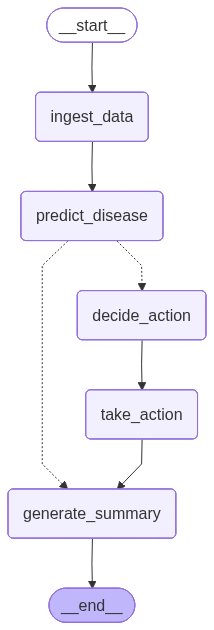

In [35]:
from IPython.display import Image,display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [48]:
print("STARTING")
initial_input = {"patient_data": {"patientId": "128"}}
final_state = {}

# app.invoke(initial_input)

# # Stream events until the end
for event in app.stream(initial_input, stream_mode="values"):
    print("--- State Update ---")
    print(event)
    final_state = event

print("\n --- FINAL SUMMARY --- ")
print(final_state['final_summary'])

STARTING
--- State Update ---
{'patient_data': {'patientId': '128'}}
NODE: INGEST DATA
INGESTION AGENT: Fetching data for patient 128 from EHR API---
INGESTION AGENT: Successfully retrieved data for patient 128
--- State Update ---
{'patient_data': {'id': '6904568df686e63234a3a8e6', 'patientName': 'Dev', 'patientMail': 'divyanshukm18@gmail.com', 'patientId': 'patient_128', 'demographics': {'age': 22, 'gender': 'Male', 'bloodGroup': 'O+', 'address': 'Mumbai, India'}, 'labResults': {'cholesterol': '190 mg/dL', 'bloodPressure': '120/80', 'sugarLevel': '95 mg/dL'}, 'voiceAnalysis': {'fo': 88.333, 'fhi': 112.24, 'flo': 84.072, 'Jitter_percent': 0.00505, 'Jitter_Abs': 6e-05, 'RAP': 0.00254, 'PPQ': 0.0033, 'DDP': 0.00763, 'Shimmer': 0.02143, 'Shimmer_dB': 0.197, 'APQ3': 0.01079, 'APQ5': 0.01342, 'APQ': 0.01892, 'DDA': 0.03237, 'NHR': 0.01166, 'HNR': 21.118, 'RPDE': 1, 'DFA': 0.611137, 'spread1': 0.776156, 'spread2': -5.24977, 'D2': 0.391002, 'PPE': 2.407313, 'extra': 0.24974}}}
NODE: PREDICT 

d:\AI\AgenticLanggraph\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ROUTING: Risk level is High
--- State Update ---
{'patient_data': {'id': '6904568df686e63234a3a8e6', 'patientName': 'Dev', 'patientMail': 'divyanshukm18@gmail.com', 'patientId': 'patient_128', 'demographics': {'age': 22, 'gender': 'Male', 'bloodGroup': 'O+', 'address': 'Mumbai, India'}, 'labResults': {'cholesterol': '190 mg/dL', 'bloodPressure': '120/80', 'sugarLevel': '95 mg/dL'}, 'voiceAnalysis': {'fo': 88.333, 'fhi': 112.24, 'flo': 84.072, 'Jitter_percent': 0.00505, 'Jitter_Abs': 6e-05, 'RAP': 0.00254, 'PPQ': 0.0033, 'DDP': 0.00763, 'Shimmer': 0.02143, 'Shimmer_dB': 0.197, 'APQ3': 0.01079, 'APQ5': 0.01342, 'APQ': 0.01892, 'DDA': 0.03237, 'NHR': 0.01166, 'HNR': 21.118, 'RPDE': 1, 'DFA': 0.611137, 'spread1': 0.776156, 'spread2': -5.24977, 'D2': 0.391002, 'PPE': 2.407313, 'extra': 0.24974}}, 'prediction_result': {'risk_level': 'High', 'reason': "Model positive for Parkinson's (Prob: 75.25%) based on voice analysis.", 'recommendation': 'Urgent consultation with a neurologist is recommen